<a href="https://colab.research.google.com/github/lucianistrati/Lab-Homeworks/blob/master/Assignment_1_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1: Bucharest Housing Dataset





## Dataset Description
In the dataset linked below you have over three thousand apartments listed for sale on the locally popular website *imobiliare.ro*. Each entry provides details about different aspects of the house or apartment:
1. `Nr Camere` indicates the number of rooms;
2. `Suprafata` specifies the total area of the dwelling;
3. `Etaj` specifies the floor that the home is located at;
4. `Total Etaje` is the total number of floors of the block of flats;
5. `Sector` represents the administrative district of Bucharest in which the apartment is located;
6. `Pret` represents the listing price of each dwelling;
7. `Scor` represents a rating between 1 and 5 of location of the apartment. It was computed in the following manner by the dataset creator:
  1. The initial dataset included the address of each flat;
  2. An extra dataset was used, which included the average sales price of dwellings in different areas of town;
  3. Using all of these monthly averages, a clusterization algorithm grouped them into 5 classes, which were then labelled 1-5;
  4. You can think of these scores as an indication of the value of the surrounding area, with 1 being expensive, and 5 being inexpensive.

Dataset Source: [kaggle.com/denisadutca](https://www.kaggle.com/denisadutca/bucharest-house-price-dataset/kernels)




## To Do

To complete this assignment, you must:
1. Get the data in a PyTorch-friendly format;
2. Predict the `Nr Camere` of each dwelling, treating it as a **classification** problem. Choose an appropriate loss function;
3. Predict the `Nr Camere` of each dwelling, treating it as a **regression** problem. Choose an appropriate loss function;
4. Compare the results of the two approaches, displaying the Confusion Matrix for the two, as well as any comparing any other metrics you think are interesting (e.g. MSE). Comment on the results;
5. Choose to predict a feature more suitable to be treated as a **regression** problem, then successfully solve it.
6. What values should the loss have when the predictions are random (when your network is not trained at all)?
7. Don't forget to split the dataset in training and validation.




## Hints
1. It might prove useful to link your Google Drive to this Notebook. See the code cell below;
2. You might want to think of ways of preprocessing your data (e.g. One Hot Encoding, etc.);
3. Don't be afraid of using text cells to actually write your thoughts about the data/results. Might prove useful at the end of the semester when you'll need to walk us through your solution 😉.



## Deadline
March 18, 2021, 23:59

**Punctaj maxim:** 2 puncte.

Depunctarea este de 0.25 puncte pe zi intarziata. Dupa mai mult de 4 zile intarziere, punctajul maxim care se poate obtine ramane 1 punct.

Trimite notebookul si datasetul intr-o arhiva `NumePrenume_Grupa_Tema1.zip` aici: https://forms.gle/MGrLvehEjmtWmQZP7 (la sustinerea temei, vei rula codul din arhiva).

In [5]:
#@title Default title text
from google.colab import drive
drive.mount('/content/gdrive')



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [1]:
!pip install torchviz
from functools import partial
from IPython.display import HTML
import math
import matplotlib.pyplot as plt
from matplotlib import animation, rc
import numpy as np
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchviz
from typing import Iterator

     |████████████████████████████████| 51kB 7.4MB/s 
  Created wheel for torchviz: filename=torchviz-0.0.1-cp37-none-any.whl size=3520 sha256=780002808bbc3280be4df08e995f752e191267c3b44bff7145fa04258a3606fa
  Stored in directory: /root/.cache/pip/wheels/2a/c2/c5/b8b4d0f7992c735f6db5bfa3c5f354cf36502037ca2b585667
Successfully built torchviz


In [28]:
import pandas as pd
import numpy as np
import os
from torch.utils.data import Dataset, DataLoader, RandomSampler, Sampler, Subset

In [11]:
df = pd.read_csv(os.path.join("sample_data","Bucharest_HousePriceDataset.csv"))
DATASET_PATH = os.path.join("sample_data","Bucharest_HousePriceDataset.csv")

In [6]:
df.head()

,Nr Camere,Suprafata,Etaj,Total Etaje,Sector,Scor,Pret
0,4,108.00,2,3,4,5,83000
1,1,41.00,1,8,1,1,39900
2,3,63.52,1,3,2,3,84900
3,1,33.00,3,10,5,1,45500
4,2,62.00,5,9,5,5,54900


In [40]:
class HousePrice_Dataset(Dataset):
  def __init__(self, csv_path, target_feature):
      """
      Args:
          csv_file (string): Path to the csv file with annotations.
          root_dir (string): Directory with all the images.
          transform (callable, optional): Optional transform to be applied
              on a sample.
      """
      self.target_feature = target_feature 
      self.dataframe = pd.read_csv(csv_path)
      self.data = self.dataframe.loc[:, self.dataframe.columns != self.target_feature]
      self.labels = self.dataframe.loc[:, self.target_feature]
      self.csv_path = csv_path 

  def __len__(self):
      return len(self.dataframe)

  def __getitem__(self, idx):
      return df.iloc[idx]

In [137]:

target_feature = 'Nr Camere'
hp_dataset = HousePrice_Dataset(DATASET_PATH, target_feature)
features_list = hp_dataset.dataframe.columns.tolist()
print(hp_dataset.dataframe.head())
hp_dataset.dataframe.iloc[:][target_feature] -= 1 
print(hp_dataset.dataframe.head())
num_classes = max(hp_dataset.dataframe.iloc[:][target_feature]) + 2

# RandomSampler retrieves elements randomly from list
sampler = RandomSampler(hp_dataset)

# instantiate DataLoader
dataloader = DataLoader(hp_dataset, batch_size=32, sampler=sampler)
from sklearn.model_selection import train_test_split
def train_val_dataset(dataset, val_split=0.2):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    return datasets

datasets_dict = train_val_dataset(hp_dataset)

train_data = []
train_labels = []
for i in range(len(datasets_dict['train'])):
    row = datasets_dict['train'][i]
    train_data.append(np.array([row[feature] for feature in features_list if feature != target_feature]))
    train_labels.append(datasets_dict['train'][i][target_feature])
train_data = torch.FloatTensor(train_data)
train_labels = torch.LongTensor(train_labels)
print(train_data.shape, train_labels.shape)

val_data = []
val_labels = []
for i in range(len(datasets_dict['val'])):
    row = datasets_dict['val'][i]
    val_data.append(np.array([row[feature] for feature in features_list if feature != target_feature]))
    val_labels.append(datasets_dict['train'][i][target_feature])
val_data = torch.FloatTensor(val_data)
val_labels = torch.LongTensor(val_labels)
print(val_data.shape, val_labels.shape)

print("There are " + str(num_classes) + " classes in our dataset")

def plot_loss(loss: list, label: str, color: str = 'blue'):
    """Plot the evolution of the loss function"""
    plt.plot(loss, label=label, color=color)
    plt.legend()

   Nr Camere  Suprafata  Etaj  Total Etaje  Sector  Scor   Pret
0          4     108.00     2            3       4     5  83000
1          1      41.00     1            8       1     1  39900
2          3      63.52     1            3       2     3  84900
3          1      33.00     3           10       5     1  45500
4          2      62.00     5            9       5     5  54900
   Nr Camere  Suprafata  Etaj  Total Etaje  Sector  Scor   Pret
0          3     108.00     2            3       4     5  83000
1          0      41.00     1            8       1     1  39900
2          2      63.52     1            3       2     3  84900
3          0      33.00     3           10       5     1  45500
4          1      62.00     5            9       5     5  54900
torch.Size([2823, 6]) torch.Size([2823])
torch.Size([706, 6]) torch.Size([706])
There are 10 classes in our dataset


EPOCH 0:
loss = 10231.103515625
EPOCH 10:
loss = 1.4596229791641235
EPOCH 20:
loss = 1.2839057445526123
EPOCH 30:
loss = 1.280558466911316
EPOCH 40:
loss = 1.2546221017837524
EPOCH 50:
loss = 1.255977749824524
EPOCH 60:
loss = 1.254025936126709
EPOCH 70:
loss = 1.2539249658584595
EPOCH 80:
loss = 1.2535511255264282
EPOCH 90:
loss = 1.2535364627838135
EPOCH 100:
loss = 1.2534550428390503
EPOCH 110:
loss = 1.253432273864746
EPOCH 120:
loss = 1.2534586191177368
EPOCH 130:
loss = 1.2534228563308716
EPOCH 140:
loss = 1.253373146057129
EPOCH 150:
loss = 1.2533622980117798
EPOCH 160:
loss = 1.2533541917800903
EPOCH 170:
loss = 1.2533706426620483
EPOCH 180:
loss = 1.253349781036377
EPOCH 190:
loss = 1.253324270248413
EPOCH 199:
loss = 1.2533247470855713


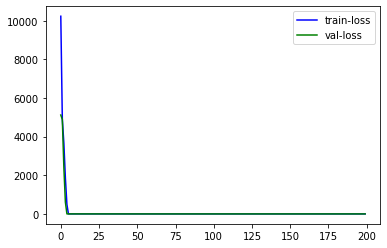

In [148]:
# classification on NrCamere approach
class ClassifNN(nn.Module):
    def __init__(self, 
                 input_size: int, 
                 hidden_size: int, 
                 output_size: int,
                 hidden_activation_fn = nn.ReLU()):
        # Initialise the base class (nn.Module)
        super().__init__()

        # As stated above, we'll simply use `torch.nn.Linear` to define our 2 layers
        self._layer1 = nn.Linear(input_size, hidden_size)
        self._layer2 = nn.Linear(hidden_size, hidden_size)
        self._layer3 = nn.Linear(hidden_size, output_size)

        self._hidden_activation = hidden_activation_fn
   
    def forward(self, x):
        # Layer 1 using ReLU as activation
        h1 = self._hidden_activation(self._layer1(x))

        h2 = self._hidden_activation(self._layer2(h1))
        # Because we will use CrossEntropy as our loss, we don't need a
        # a softmax activation function after layer 2
        out = self._layer3(h2)
        
        return out

# Finally, train the network and plot the decision boundaries
model_classifier = ClassifNN(6, 10, num_classes)

NUM_EPOCHS = 200
PRINT_EVERY = 10

train_loss = []
val_loss = [] # This time we will track the loss on val_data

learning_rate = 1e-1
optim = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

for i in range(NUM_EPOCHS):
    # Set the model to train mode and reset the gradients
    model_classifier.train()
    optim.zero_grad()

    output = model_classifier(train_data)

    loss = criterion(output, train_labels)
    
    loss.backward()
    optim.step()
    
    train_loss.append(loss.detach().numpy())

    if i % PRINT_EVERY == 0 or i == NUM_EPOCHS - 1:
        print(f'EPOCH {i}:')
        print(f'loss = {loss.item()}')
  
    # Every epoch, let's evaluate our model on the validation data and plot both losses at the end
    model_classifier.eval() # set the model to evaluation mode
    with torch.no_grad():
        output = model_classifier(val_data)
        validation_loss = F.cross_entropy(output, val_labels)
        val_loss.append(validation_loss)

plot_loss(train_loss, 'train-loss')
plot_loss(val_loss, 'val-loss', color='green')


In [174]:
target_feature = 'Nr Camere'
hp_dataset = HousePrice_Dataset(DATASET_PATH, target_feature)
features_list = hp_dataset.dataframe.columns.tolist()


# RandomSampler retrieves elements randomly from list
sampler = RandomSampler(hp_dataset)

# instantiate DataLoader
dataloader = DataLoader(hp_dataset, batch_size=32, sampler=sampler)
from sklearn.model_selection import train_test_split
def train_val_dataset(dataset, val_split=0.2):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    return datasets

datasets_dict = train_val_dataset(hp_dataset)

train_data = []
train_labels = []
for i in range(len(datasets_dict['train'])):
    row = datasets_dict['train'][i]
    train_data.append(np.array([row[feature] for feature in features_list if feature != target_feature]))
    train_labels.append(datasets_dict['train'][i][target_feature])
train_data = torch.FloatTensor(train_data)
train_labels = torch.FloatTensor(train_labels)
print(train_data.shape, train_labels.shape)

val_data = []
val_labels = []
for i in range(len(datasets_dict['val'])):
    row = datasets_dict['val'][i]
    val_data.append(np.array([row[feature] for feature in features_list if feature != target_feature]))
    val_labels.append(datasets_dict['train'][i][target_feature])
val_data = torch.FloatTensor(val_data)
val_labels = torch.FloatTensor(val_labels)
print(val_data.shape, val_labels.shape)


def plot_loss(loss: list, label: str, color: str = 'blue'):
    """Plot the evolution of the loss function"""
    plt.plot(loss, label=label, color=color)
    plt.legend()

torch.Size([2823, 6]) torch.Size([2823])
torch.Size([706, 6]) torch.Size([706])


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([2823])) that is different to the input size (torch.Size([2823, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: Using a target size (torch.Size([706])) that is different to the input size (torch.Size([706, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


EPOCH 0:
loss = 23716572.0
EPOCH 10:
loss = 23716572.0
EPOCH 20:
loss = 23716572.0
EPOCH 30:
loss = 23716572.0
EPOCH 40:
loss = 23716572.0
EPOCH 50:
loss = 23716572.0
EPOCH 60:
loss = 23716572.0
EPOCH 70:
loss = 23716572.0
EPOCH 80:
loss = 23716572.0
EPOCH 90:
loss = 23716572.0
EPOCH 100:
loss = 23716572.0
EPOCH 110:
loss = 23716572.0
EPOCH 120:
loss = 23716572.0
EPOCH 130:
loss = 23716572.0
EPOCH 140:
loss = 23716572.0
EPOCH 150:
loss = 23716572.0
EPOCH 160:
loss = 23716572.0
EPOCH 170:
loss = 23716572.0
EPOCH 180:
loss = 23716572.0
EPOCH 190:
loss = 23716572.0
EPOCH 199:
loss = 23716572.0


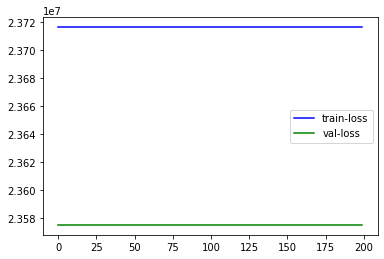

In [176]:
# regression on NrCamere approach
class RegressNN(nn.Module):
    def __init__(self, 
                 input_size: int, 
                 hidden_size: int, 
                 output_size: int,
                 hidden_activation_fn = nn.ReLU()):
        # Initialise the base class (nn.Module)
        super().__init__()

        # As stated above, we'll simply use `torch.nn.Linear` to define our 2 layers
        self._layer1 = nn.Linear(input_size, hidden_size)
        self._layer2 = nn.Linear(hidden_size, hidden_size)
        self._layer3 = nn.Linear(hidden_size, output_size)

        self._hidden_activation = hidden_activation_fn
   
    def forward(self, x):
        # Layer 1 using ReLU as activation
        h1 = self._hidden_activation(self._layer1(x))

        h2 = self._hidden_activation(self._layer2(h1))
        # Because we will use CrossEntropy as our loss, we don't need a
        # a softmax activation function after layer 2
        out = self._layer3(h2)
        
        return out

# Finally, train the network and plot the decision boundaries
model_regressor = RegressNN(6, 10, 1)

NUM_EPOCHS = 200
PRINT_EVERY = 10

train_loss = []
val_loss = [] # This time we will track the loss on val_data

learning_rate = 1e-1
optim = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

for i in range(NUM_EPOCHS):
    # Set the model to train mode and reset the gradients
    model_regressor.train()
    optim.zero_grad()

    output = model_regressor(train_data)

    loss = criterion(output, train_labels)
    
    loss.backward()
    optim.step()
    
    train_loss.append(loss.detach().numpy())

    if i % PRINT_EVERY == 0 or i == NUM_EPOCHS - 1:
        print(f'EPOCH {i}:')
        print(f'loss = {loss.item()}')
  
    # Every epoch, let's evaluate our model on the validation data and plot both losses at the end
    model_regressor.eval() # set the model to evaluation mode
    with torch.no_grad():
        output = model_regressor(val_data)
        validation_loss = F.mse_loss(output, val_labels)
        val_loss.append(validation_loss)

plot_loss(train_loss, 'train-loss')
plot_loss(val_loss, 'val-loss', color='green')




In [163]:
# approach comparison 
# metrics: confusion matrix, mse, mae, rmse, mape, 



In [181]:
# regression on Pret approach
target_feature = 'Pret'
hp_dataset = HousePrice_Dataset(DATASET_PATH, target_feature)
features_list = hp_dataset.dataframe.columns.tolist()

# RandomSampler retrieves elements randomly from list
sampler = RandomSampler(hp_dataset)

# instantiate DataLoader
dataloader = DataLoader(hp_dataset, batch_size=32, sampler=sampler)
from sklearn.model_selection import train_test_split
def train_val_dataset(dataset, val_split=0.2):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    return datasets

datasets_dict = train_val_dataset(hp_dataset)

train_data = []
train_labels = []
for i in range(len(datasets_dict['train'])):
    row = datasets_dict['train'][i]
    train_data.append(np.array([row[feature] for feature in features_list if feature != target_feature]))
    train_labels.append(datasets_dict['train'][i][target_feature])
train_data = torch.FloatTensor(train_data)
train_labels = torch.FloatTensor(train_labels)
print(train_data.shape, train_labels.shape)

val_data = []
val_labels = []
for i in range(len(datasets_dict['val'])):
    row = datasets_dict['val'][i]
    val_data.append(np.array([row[feature] for feature in features_list if feature != target_feature]))
    val_labels.append(datasets_dict['train'][i][target_feature])
val_data = torch.FloatTensor(val_data)
val_labels = torch.FloatTensor(val_labels)
print(val_data.shape, val_labels.shape)


def plot_loss(loss: list, label: str, color: str = 'blue'):
    """Plot the evolution of the loss function"""
    plt.plot(loss, label=label, color=color)
    plt.legend()

torch.Size([2823, 6]) torch.Size([2823])
torch.Size([706, 6]) torch.Size([706])


EPOCH 0:
loss = 2.6083202362060547
EPOCH 10:
loss = 2.6083202362060547
EPOCH 20:
loss = 2.6083202362060547
EPOCH 30:
loss = 2.6083202362060547
EPOCH 40:
loss = 2.6083202362060547
EPOCH 50:
loss = 2.6083202362060547
EPOCH 60:
loss = 2.6083202362060547
EPOCH 70:
loss = 2.6083202362060547
EPOCH 80:
loss = 2.6083202362060547
EPOCH 90:
loss = 2.6083202362060547
EPOCH 100:
loss = 2.6083202362060547
EPOCH 110:
loss = 2.6083202362060547
EPOCH 120:
loss = 2.6083202362060547
EPOCH 130:
loss = 2.6083202362060547
EPOCH 140:
loss = 2.6083202362060547
EPOCH 150:
loss = 2.6083202362060547
EPOCH 160:
loss = 2.6083202362060547
EPOCH 170:
loss = 2.6083202362060547
EPOCH 180:
loss = 2.6083202362060547
EPOCH 190:
loss = 2.6083202362060547
EPOCH 199:
loss = 2.6083202362060547


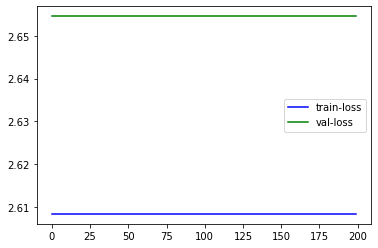

In [183]:
# regression on Pret approach
class RegressNN(nn.Module):
    def __init__(self, 
                 input_size: int, 
                 hidden_size: int, 
                 output_size: int,
                 hidden_activation_fn = nn.ReLU()):
        # Initialise the base class (nn.Module)
        super().__init__()

        # As stated above, we'll simply use `torch.nn.Linear` to define our 2 layers
        self._layer1 = nn.Linear(input_size, hidden_size)
        self._layer2 = nn.Linear(hidden_size, hidden_size)
        self._layer3 = nn.Linear(hidden_size, output_size)

        self._hidden_activation = hidden_activation_fn
   
    def forward(self, x):
        # Layer 1 using ReLU as activation
        h1 = self._hidden_activation(self._layer1(x))

        h2 = self._hidden_activation(self._layer2(h1))
        # Because we will use CrossEntropy as our loss, we don't need a
        # a softmax activation function after layer 2
        out = self._layer3(h2)
        
        return out

# Finally, train the network and plot the decision boundaries
model_regressor = RegressNN(6, 10, 1)

NUM_EPOCHS = 200
PRINT_EVERY = 10

train_loss = []
val_loss = [] # This time we will track the loss on val_data

learning_rate = 1e-1
optim = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
criterion = nn.HingeEmbeddingLoss()

for i in range(NUM_EPOCHS):
    # Set the model to train mode and reset the gradients
    model_regressor.train()
    optim.zero_grad()

    output = model_regressor(train_data)

    loss = criterion(output, train_labels)
    
    loss.backward()
    optim.step()
    
    train_loss.append(loss.detach().numpy())

    if i % PRINT_EVERY == 0 or i == NUM_EPOCHS - 1:
        print(f'EPOCH {i}:')
        print(f'loss = {loss.item()}')
  
    # Every epoch, let's evaluate our model on the validation data and plot both losses at the end
    model_regressor.eval() # set the model to evaluation mode
    with torch.no_grad():
        output = model_regressor(val_data)
        validation_loss = F.hinge_embedding_loss(output, val_labels)
        val_loss.append(validation_loss)

plot_loss(train_loss, 'train-loss')
plot_loss(val_loss, 'val-loss', color='green')
